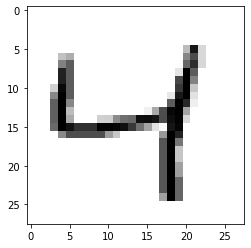

In [5]:
import data
import matplotlib.pyplot as plt


data_train, data_test = data.get_datasets()
plt.imshow(data_train[2][0].squeeze(), cmap="gray_r")

In [6]:
from torch import nn
from copy import deepcopy

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self._flatten = nn.Flatten()
        self._model = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.Sigmoid(),
            nn.Linear(32, 10)
        )
        self._flatten.requires_grad_(False)
        self._model.requires_grad_(False)
        self.requires_grad_(False)

    def forward(self, x):
        return self._model(self._flatten(x))

    def child(self, std_dev: float) -> 'Model':
        child = deepcopy(self)
        for p in self.parameters():
            p.add_(torch.randn(p.size()) * std_dev)
        return child


In [8]:
import torch
from tqdm.notebook import tqdm
from typing import List


loss_function = nn.CrossEntropyLoss()
loss_function.requires_grad_(False)
num_parents = 4
mutation_per_parent = 4
std_dev = 0.1


def train(candidates: List[Model]):
    X = data_train.data
    y = data_train.targets
    candidates.extend(
        [parent.child(std_dev) for parent in candidates for _ in range(mutation_per_parent)]
    )
    eval_candidates = [(candidate, loss_function(candidate(X), y).item()) for candidate in candidates]
    eval_candidates.sort(key=lambda c: c[1])

    candidates = list(map(lambda c: c[0], eval_candidates[0:num_parents]))

    return candidates

@torch.no_grad()
def test(model: Model):
    test_loss = 0.0
    accuracy = 0.0
    X = data_test.data
    y = data_test.targets
    pred = model(X)
    test_loss = loss_function(pred, y).item()
    accuracy += (torch.argmax(pred, dim=1) == torch.argmax(y, dim=1)).type(torch.float).mean()
    tqdm.write(f"Test -> Loss: {test_loss}, accuracy: {accuracy}")

In [9]:
import torch
from tqdm.notebook import trange


torch.manual_seed(666)
candidates = [Model() for _ in range(num_parents)]

for epoch in trange(1, 2001, desc="Epoch"):
    candidates = train(candidates)
    if epoch % 100 == 0:
        model = candidates[0]
        test(model)

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

RuntimeError: expected scalar type Float but found Byte